In [ ]:
import pandas as pd
import numpy as np
import os
import datetime

def train_test_split(df,train,val,test):
    n=len(df)
    train_df=df[0:int(n*train)]
    val_df=df[int(n*train):int(n*(train+val))]
    test_df=df[int(n*(train+val)):]
    
    return train_df,val_df,test_df

def create_dataset(X, y, time_steps=1):

    Xs, ys = [], []

    for i in range(len(X) - time_steps):

        v = X.iloc[i:(i + time_steps)].values

        Xs.append(v)

        ys.append(y.iloc[i + time_steps])

    return np.array(Xs), np.array(ys)


def m_create_dataset(X, y, time_steps=1):

    Xs, ys = [], []

    for i in range(len(X) - time_steps-4):

        v = X.iloc[i:(i + time_steps)].values

        Xs.append(v)

        #ys.append(y.iloc[i + time_steps+30])
        ys.append(np.array(y.iloc[(i + time_steps):(i + time_steps+4)].values))
        

    return np.array(Xs), np.array(ys)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [ ]:
alaska_df=pd.read_csv('/content/drive/MyDrive/alaska/99709.csv')

In [ ]:
alaska_df.head()

,date_time,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,moonrise,moonset,sunrise,sunset,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph,location
0,2008-07-01 00:00:00,15,9,0.0,-2.7,3,4,12:00 AM,12:00 AM,03:12 AM,12:39 AM,9,8,9,8,13,90,98,1.0,1017,9,9,248,8,99709
1,2008-07-01 03:00:00,15,9,0.0,-2.7,3,4,12:00 AM,12:00 AM,03:12 AM,12:39 AM,8,7,9,7,12,100,97,1.4,1017,9,9,231,8,99709
2,2008-07-01 06:00:00,15,9,0.0,-2.7,3,4,12:00 AM,12:00 AM,03:12 AM,12:39 AM,8,8,9,8,16,84,94,0.5,1016,9,2,237,10,99709
3,2008-07-01 09:00:00,15,9,0.0,-2.7,3,4,12:00 AM,12:00 AM,03:12 AM,12:39 AM,8,9,10,9,15,100,88,1.2,1015,10,9,239,11,99709
4,2008-07-01 12:00:00,15,9,0.0,-2.7,3,4,12:00 AM,12:00 AM,03:12 AM,12:39 AM,7,7,9,7,16,94,89,0.3,1015,9,2,241,12,99709


In [ ]:
alaska_df['date_time'] = pd.to_datetime(alaska_df['date_time'], format='%Y-%m-%d')

In [ ]:
alaska_df=alaska_df.set_index('date_time')

In [ ]:
alasks_prec=pd.DataFrame(alaska_df.reset_index().resample('D', on='date_time').sum()['precipMM'])
alasks_snow=pd.DataFrame(alaska_df.reset_index().resample('D', on='date_time').sum()['totalSnow_cm'])
alaska_mean=alaska_df.reset_index().resample('D', on='date_time').mean()


In [ ]:
alaska_features=alaska_mean[['maxtempC','mintempC','tempC','DewPointC','humidity','cloudcover']]

In [ ]:
data=pd.concat([alaska_features,alasks_snow,alasks_prec],axis=1)
data

,maxtempC,mintempC,tempC,DewPointC,humidity,cloudcover,totalSnow_cm,precipMM
date_time,,,,,,,,
2008-07-01,15.0,9.0,11.000,8.500,86.250,79.125,0.0,6.9
2008-07-02,23.0,7.0,15.875,4.500,53.375,7.750,0.0,0.2
2008-07-03,27.0,11.0,20.500,2.375,33.375,6.625,0.0,0.0
2008-07-04,28.0,13.0,21.125,7.625,44.750,5.875,0.0,0.0
2008-07-05,25.0,12.0,19.875,7.125,45.500,4.375,0.0,0.0
...,...,...,...,...,...,...,...,...
2020-12-27,-15.0,-20.0,-17.250,-17.500,86.250,36.375,0.0,0.0
2020-12-28,-10.0,-18.0,-12.375,-13.000,83.125,24.125,0.0,0.0
2020-12-29,-13.0,-23.0,-15.375,-15.000,90.250,20.375,0.0,0.0


In [ ]:
data.corr()

,maxtempC,mintempC,tempC,DewPointC,humidity,cloudcover,totalSnow_cm,precipMM
maxtempC,1.000000,0.969413,0.993194,0.951602,-0.767451,-0.178324,-0.164386,0.127624
mintempC,0.969413,1.000000,0.988081,0.975123,-0.698525,-0.087875,-0.135852,0.211062
tempC,0.993194,0.988081,1.000000,0.968587,-0.747210,-0.133364,-0.145353,0.168964
DewPointC,0.951602,0.975123,0.968587,1.000000,-0.564348,-0.006947,-0.101143,0.268738
humidity,-0.767451,-0.698525,-0.747210,-0.564348,1.000000,0.442479,0.236115,0.163021
cloudcover,-0.178324,-0.087875,-0.133364,-0.006947,0.442479,1.000000,0.394806,0.428888
totalSnow_cm,-0.164386,-0.135852,-0.145353,-0.101143,0.236115,0.394806,1.000000,0.371754
precipMM,0.127624,0.211062,0.168964,0.268738,0.163021,0.428888,0.371754,1.000000


In [ ]:
alaska_df.head()

,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,moonrise,moonset,sunrise,sunset,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph,location
date_time,,,,,,,,,,,,,,,,,,,,,,,,
2008-07-01 00:00:00,15,9,0.0,-2.7,3,4,12:00 AM,12:00 AM,03:12 AM,12:39 AM,9,8,9,8,13,90,98,1.0,1017,9,9,248,8,99709
2008-07-01 03:00:00,15,9,0.0,-2.7,3,4,12:00 AM,12:00 AM,03:12 AM,12:39 AM,8,7,9,7,12,100,97,1.4,1017,9,9,231,8,99709
2008-07-01 06:00:00,15,9,0.0,-2.7,3,4,12:00 AM,12:00 AM,03:12 AM,12:39 AM,8,8,9,8,16,84,94,0.5,1016,9,2,237,10,99709
2008-07-01 09:00:00,15,9,0.0,-2.7,3,4,12:00 AM,12:00 AM,03:12 AM,12:39 AM,8,9,10,9,15,100,88,1.2,1015,10,9,239,11,99709
2008-07-01 12:00:00,15,9,0.0,-2.7,3,4,12:00 AM,12:00 AM,03:12 AM,12:39 AM,7,7,9,7,16,94,89,0.3,1015,9,2,241,12,99709


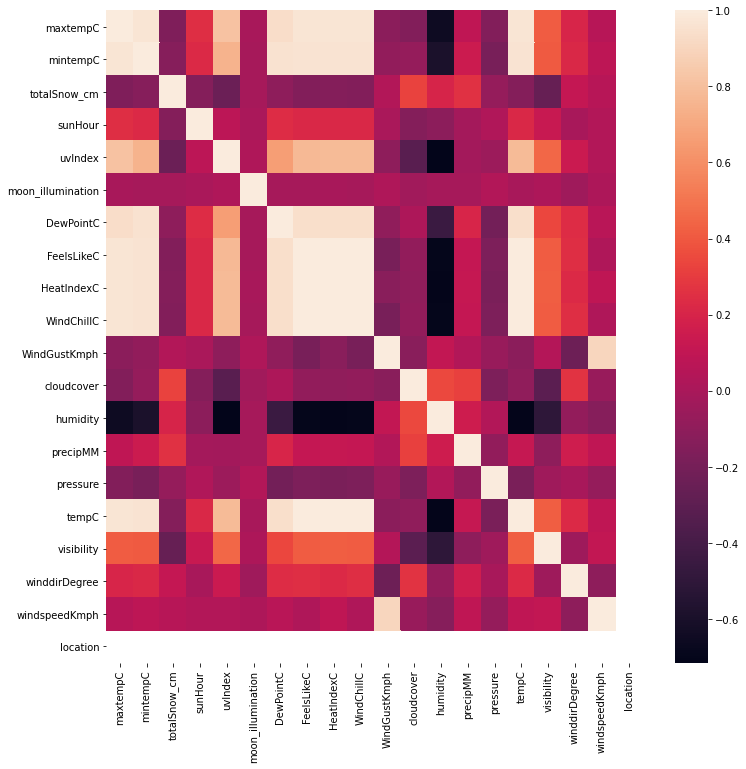

In [ ]:
plt.figure(figsize=(12,12))
sns.heatmap(alaska_df.corr()) ## heatmap

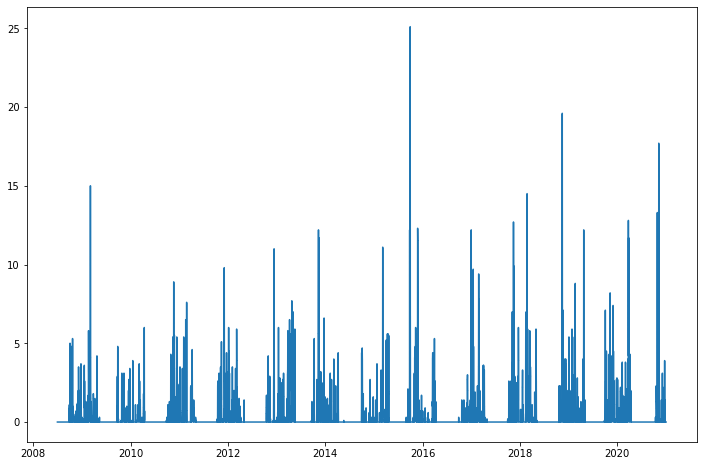

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(alaska_df['totalSnow_cm'])

In [ ]:
import tensorflow as tf
from tensorflow import keras

time_steps = 120

### LSTM parameters
lstm_units= 256
lstm_dropout=0.4
learning_rate=0.0001
stop_patience=15
max_epocs=500
lstm_batch_size=64


forcing_train,forcing_val,forcing_test=train_test_split(alaska_df,0.6,0.2,0.2)

### normalize data
forcing_mean = forcing_train.mean()
forcing_std = forcing_train.std()

forcing_train = (forcing_train - forcing_mean) / forcing_std
forcing_val = (forcing_val - forcing_mean) / forcing_std
forcing_test = (forcing_test - forcing_mean) / forcing_std

### create sequences of data
x_train, y_train = create_dataset(forcing_train[['cloudcover','totalSnow_cm']] ,forcing_train['totalSnow_cm'], time_steps)
print(x_train.shape, y_train.shape)

x_val, y_val = create_dataset(forcing_val[['cloudcover','totalSnow_cm']] , forcing_val['totalSnow_cm'], time_steps)
print(x_val.shape, y_val.shape)

x_test, y_test = create_dataset(forcing_test[['cloudcover','totalSnow_cm']] , forcing_test['totalSnow_cm'], time_steps)
print(x_test.shape, y_test.shape)

### build model and training
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units)),
    tf.keras.layers.Dropout(rate=lstm_dropout),
    tf.keras.layers.Dense(1, kernel_initializer=tf.initializers.zeros())])

customAdam = keras.optimizers.Adam(lr=learning_rate)   
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=stop_patience,
                                                    mode='min')

lstm_model.compile(loss=tf.losses.MeanSquaredError(),
            optimizer=customAdam,
            metrics=[tf.metrics.RootMeanSquaredError()])

history = lstm_model.fit(x_train, y_train ,epochs=max_epocs,
                  batch_size=lstm_batch_size,
                  validation_data=(x_val,y_val), 
                  callbacks=[early_stopping],shuffle=True)


### Evaluate the model

val_performance= lstm_model.evaluate(x_val, y_val) 
performance= lstm_model.evaluate(x_test, y_test) 
print(performance)

(21801, 120, 2) (21801,)
(7187, 120, 2) (7187,)
(7188, 120, 2) (7188,)
Epoch 1/500


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


341/341 [==============================] - 11s 23ms/step - loss: 0.7111 - root_mean_squared_error: 0.8433 - val_loss: 0.5110 - val_root_mean_squared_error: 0.7148
Epoch 2/500
341/341 [==============================] - 7s 21ms/step - loss: 0.3834 - root_mean_squared_error: 0.6192 - val_loss: 0.3202 - val_root_mean_squared_error: 0.5659
Epoch 3/500
341/341 [==============================] - 7s 21ms/step - loss: 0.2976 - root_mean_squared_error: 0.5455 - val_loss: 0.2722 - val_root_mean_squared_error: 0.5217
Epoch 4/500
341/341 [==============================] - 7s 21ms/step - loss: 0.2721 - root_mean_squared_error: 0.5216 - val_loss: 0.2419 - val_root_mean_squared_error: 0.4918
Epoch 5/500
341/341 [==============================] - 7s 21ms/step - loss: 0.2477 - root_mean_squared_error: 0.4977 - val_loss: 0.2250 - val_root_mean_squared_error: 0.4744
Epoch 6/500
341/341 [==============================] - 7s 21ms/step - loss: 0.2306 - root_mean_squared_error: 0.4802 - val_loss: 0.2074 - val

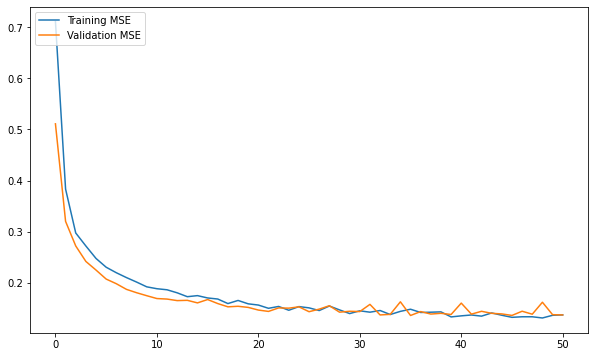

In [ ]:
plt.figure(figsize=(10,6 ))
plt.plot(history.history['loss'],label='Training MSE')
plt.plot(history.history['val_loss'], label='Validation MSE')
plt.legend(loc="upper left")
plt.show()

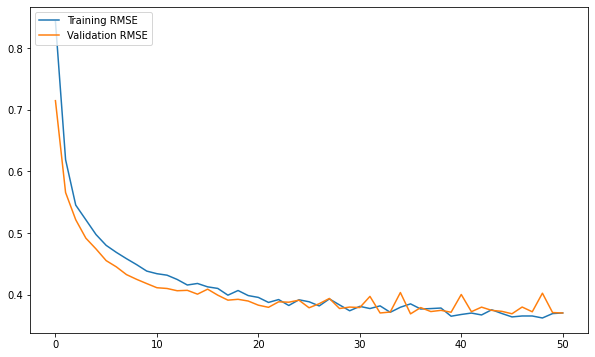

In [ ]:
plt.figure(figsize=(10,6 ))
plt.plot(history.history['root_mean_squared_error'],label='Training RMSE')
plt.plot(history.history['val_root_mean_squared_error'],label='Validation RMSE')
plt.legend(loc="upper left")
plt.show()

In [ ]:
p_train=lstm_model.predict(x_train)
p_val=lstm_model.predict(x_val)
p_test=lstm_model.predict(x_test)

y_train_inv=(y_train*forcing_std['totalSnow_cm'])+forcing_mean['totalSnow_cm']
p_train_inv=(p_train*forcing_std['totalSnow_cm'])+forcing_mean['totalSnow_cm']

y_val_inv=(y_val*forcing_std['totalSnow_cm'])+forcing_mean['totalSnow_cm']
p_val_inv=(p_val*forcing_std['totalSnow_cm'])+forcing_mean['totalSnow_cm']

y_test_inv=(y_test*forcing_std['totalSnow_cm'])+forcing_mean['totalSnow_cm']
p_test_inv=(p_test*forcing_std['totalSnow_cm'])+forcing_mean['totalSnow_cm']

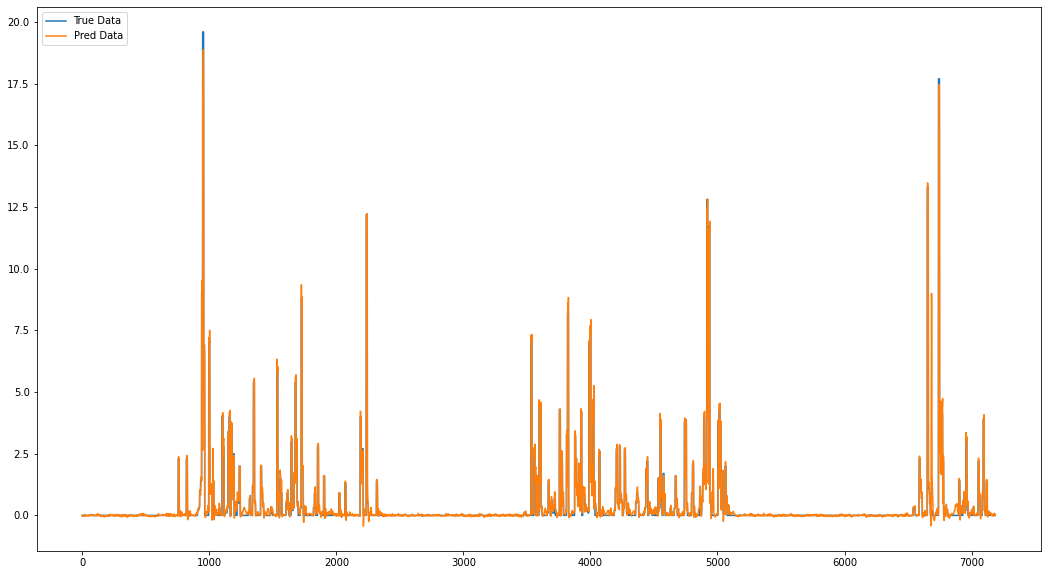

In [ ]:
plt.figure(figsize=(18,10 ))
plt.plot(y_test_inv,label='True Data')
plt.plot(p_test_inv,label='Predict Data')
plt.legend(loc="upper left")
plt.show()

Text(0, 0.5, 'Predict Data')

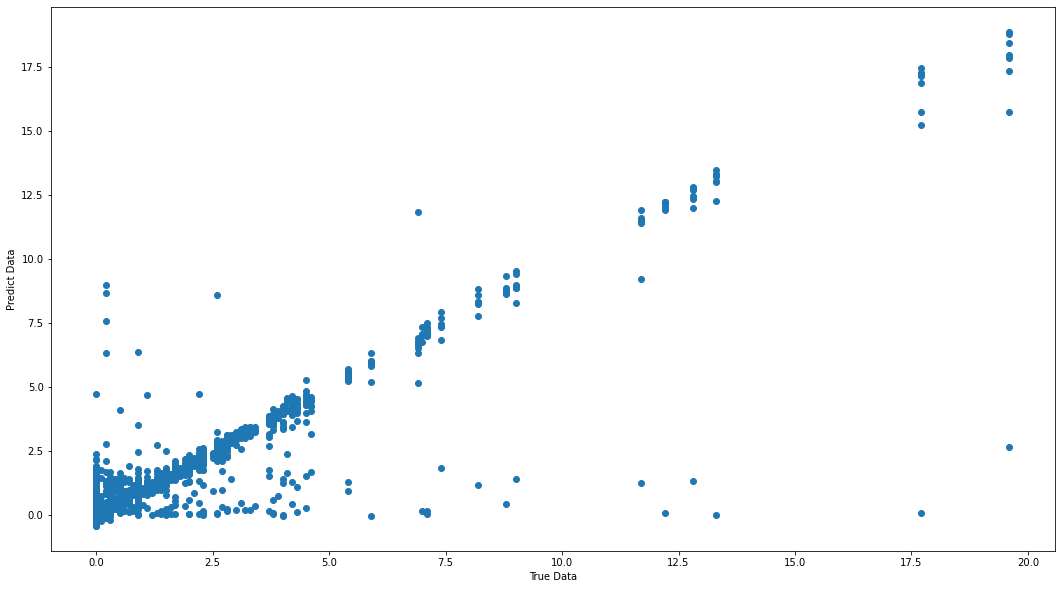

In [ ]:
plt.figure(figsize=(18,10 ))
plt.scatter(y_test_inv,p_test_inv)
plt.xlabel("True Data")
plt.ylabel("Predict Data")

In [ ]:
alaska_df.index[1].hour

3

In [ ]:
alaska_df['hour']=alaska_df['cloudcover']
for i in range(len(alaska_df)):
  alaska_df['hour'][i]=alaska_df.index[i].hour

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
alaska_df['day']=alaska_df['cloudcover']
for i in range(len(alaska_df)):
  alaska_df['day'][i]=alaska_df.index[i].day

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
alaska_df['month']=alaska_df['cloudcover']
for i in range(len(alaska_df)):
  alaska_df['month'][i]=alaska_df.index[i].month

alaska_df['year']=alaska_df['cloudcover']
for i in range(len(alaska_df)):
  alaska_df['year'][i]=alaska_df.index[i].year

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
alaska_df

,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,moonrise,moonset,sunrise,sunset,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph,location,hour,day,month,year
date_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2008-07-01 00:00:00,15,9,0.0,-2.7,3,4,12:00 AM,12:00 AM,03:12 AM,12:39 AM,9,8,9,8,13,90,98,1.0,1017,9,9,248,8,99709,0,1,7,2008
2008-07-01 03:00:00,15,9,0.0,-2.7,3,4,12:00 AM,12:00 AM,03:12 AM,12:39 AM,8,7,9,7,12,100,97,1.4,1017,9,9,231,8,99709,3,1,7,2008
2008-07-01 06:00:00,15,9,0.0,-2.7,3,4,12:00 AM,12:00 AM,03:12 AM,12:39 AM,8,8,9,8,16,84,94,0.5,1016,9,2,237,10,99709,6,1,7,2008
2008-07-01 09:00:00,15,9,0.0,-2.7,3,4,12:00 AM,12:00 AM,03:12 AM,12:39 AM,8,9,10,9,15,100,88,1.2,1015,10,9,239,11,99709,9,1,7,2008
2008-07-01 12:00:00,15,9,0.0,-2.7,3,4,12:00 AM,12:00 AM,03:12 AM,12:39 AM,7,7,9,7,16,94,89,0.3,1015,9,2,241,12,99709,12,1,7,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 09:00:00,-18,-26,0.0,1.0,2,89,05:21 PM,01:48 PM,11:56 AM,03:54 PM,-20,-19,-19,-19,6,68,95,0.0,1016,-19,2,117,3,99709,9,31,12,2020
2020-12-31 12:00:00,-18,-26,0.0,1.0,2,89,05:21 PM,01:48 PM,11:56 AM,03:54 PM,-20,-21,-19,-21,7,78,95,0.0,1016,-19,2,236,3,99709,12,31,12,2020
2020-12-31 15:00:00,-18,-26,0.0,1.0,2,89,05:21 PM,01:48 PM,11:56 AM,03:54 PM,-20,-23,-20,-23,8,69,95,0.0,1015,-20,2,119,4,99709,15,31,12,2020


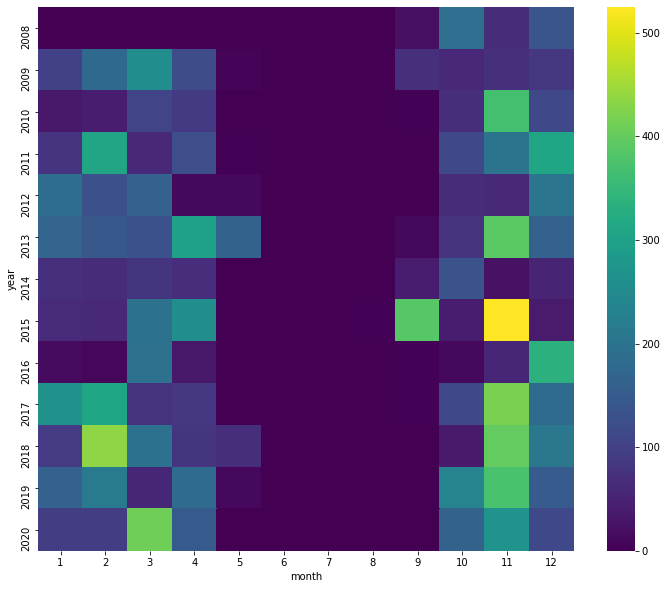

In [ ]:
plt.figure(figsize=(12,10 ))
sns.heatmap(alaska_df.groupby(['year','month']).sum()['totalSnow_cm'].unstack(level=-1).fillna(0), cmap='viridis')

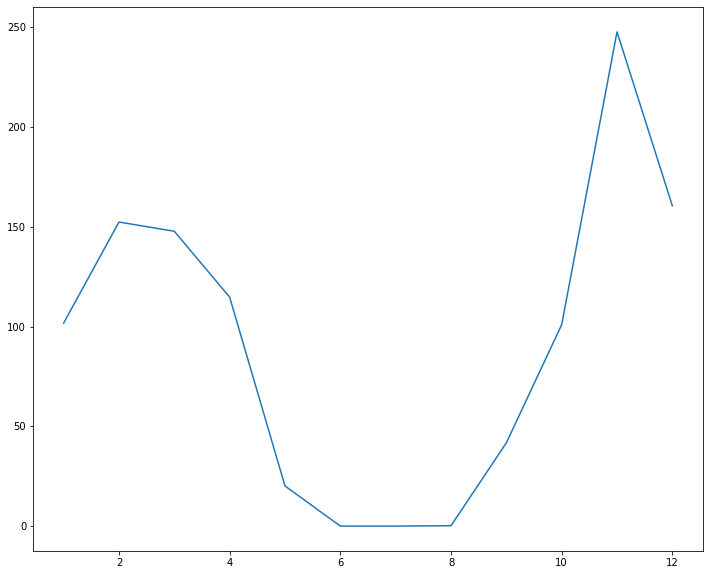

In [ ]:
plt.figure(figsize=(12,10 ))
plt.plot(alaska_df.groupby(['year','month']).sum()['totalSnow_cm'].unstack(level=-1).fillna(0).describe().loc['mean'])

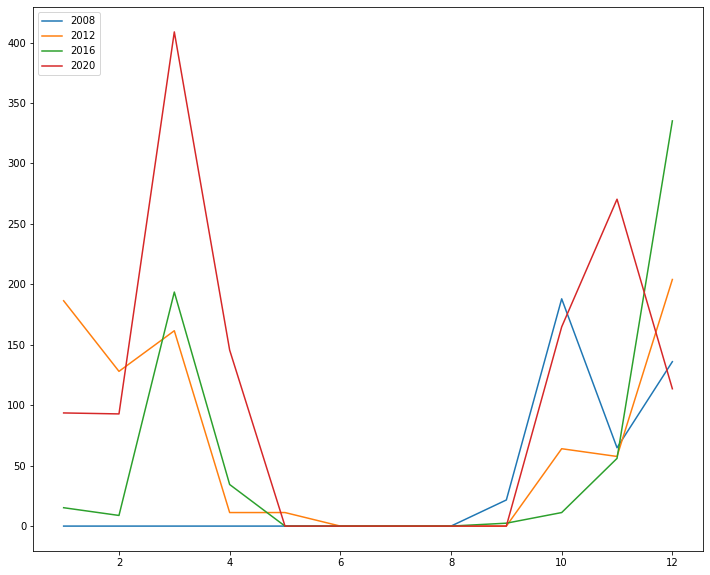

In [ ]:
plt.figure(figsize=(12,10 ))

for i in range(0,13,4):
  plt.plot(alaska_df.groupby(['year','month']).sum()['totalSnow_cm'].unstack(level=-1).fillna(0).iloc[i], label=(2008+i))
  plt.legend(loc="upper left")


In [ ]:
alaska_df.groupby(['year','month']).sum()['totalSnow_cm'].unstack(level=-1)

month,1,2,3,4,5,6,7,8,9,10,11,12
year,,,,,,,,,,,,
2008,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,21.6,188.0,64.8,136.0
2009,98.4,176.8,256.0,119.2,4.8,0.0,0.0,0.0,72.0,60.8,73.6,82.4
2010,32.8,40.0,106.4,87.2,0.0,0.0,0.0,0.0,3.2,68.8,368.0,113.6
2011,79.2,308.8,58.4,124.8,3.2,0.0,0.0,0.0,0.0,114.4,200.8,310.4
2012,186.4,128.0,161.6,11.2,11.2,0.0,0.0,0.0,0.0,64.0,57.6,204.0
2013,167.2,141.6,129.6,300.0,162.4,0.0,0.0,0.0,11.2,78.4,389.6,160.8
2014,73.6,64.0,80.8,66.4,0.8,0.0,0.0,0.0,40.8,135.2,23.2,52.8
2015,61.6,60.8,196.0,256.8,0.0,0.0,0.0,2.4,387.2,40.8,524.8,38.4
2016,15.2,8.8,193.6,34.4,0.0,0.0,0.0,0.0,2.4,11.2,56.0,335.2


In [ ]:
import tensorflow as tf
from tensorflow import keras

time_steps = 120

### LSTM parameters
lstm_units= 256
lstm_dropout=0.4
learning_rate=0.0001
stop_patience=15
max_epocs=500
lstm_batch_size=64


forcing_train,forcing_val,forcing_test=train_test_split(alaska_df,0.6,0.2,0.2)

### normalize data
forcing_mean = forcing_train.mean()
forcing_std = forcing_train.std()

forcing_train = (forcing_train - forcing_mean) / forcing_std
forcing_val = (forcing_val - forcing_mean) / forcing_std
forcing_test = (forcing_test - forcing_mean) / forcing_std

### create sequences of data
x_train, y_train = m_create_dataset(forcing_train[['cloudcover','totalSnow_cm']] ,forcing_train['totalSnow_cm'], time_steps)
print(x_train.shape, y_train.shape)

x_val, y_val = m_create_dataset(forcing_val[['cloudcover','totalSnow_cm']] , forcing_val['totalSnow_cm'], time_steps)
print(x_val.shape, y_val.shape)

x_test, y_test = m_create_dataset(forcing_test[['cloudcover','totalSnow_cm']] , forcing_test['totalSnow_cm'], time_steps)
print(x_test.shape, y_test.shape)

### build model and training
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units)),
    tf.keras.layers.Dropout(rate=lstm_dropout),
    tf.keras.layers.Dense(4, kernel_initializer=tf.initializers.zeros()),
        tf.keras.layers.Reshape([4, 1])
])

customAdam = keras.optimizers.Adam(lr=learning_rate)   
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=stop_patience,
                                                    mode='min')

lstm_model.compile(loss=tf.losses.MeanSquaredError(),
            optimizer=customAdam,
            metrics=[tf.metrics.RootMeanSquaredError()])

history = lstm_model.fit(x_train, y_train ,epochs=max_epocs,
                  batch_size=lstm_batch_size,
                  validation_data=(x_val,y_val), 
                  callbacks=[early_stopping],shuffle=True)


### Evaluate the model

val_performance= lstm_model.evaluate(x_val, y_val) 
performance= lstm_model.evaluate(x_test, y_test) 
print(performance)



(21797, 120, 2) (21797, 4)
(7183, 120, 2) (7183, 4)
(7184, 120, 2) (7184, 4)
Epoch 1/500


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


341/341 [==============================] - 11s 23ms/step - loss: 0.7719 - root_mean_squared_error: 0.8786 - val_loss: 0.6798 - val_root_mean_squared_error: 0.8245
Epoch 2/500
341/341 [==============================] - 7s 22ms/step - loss: 0.5474 - root_mean_squared_error: 0.7399 - val_loss: 0.5069 - val_root_mean_squared_error: 0.7120
Epoch 3/500
341/341 [==============================] - 7s 22ms/step - loss: 0.4612 - root_mean_squared_error: 0.6791 - val_loss: 0.4703 - val_root_mean_squared_error: 0.6857
Epoch 4/500
341/341 [==============================] - 8s 22ms/step - loss: 0.4321 - root_mean_squared_error: 0.6573 - val_loss: 0.4426 - val_root_mean_squared_error: 0.6653
Epoch 5/500
341/341 [==============================] - 8s 22ms/step - loss: 0.4120 - root_mean_squared_error: 0.6418 - val_loss: 0.4240 - val_root_mean_squared_error: 0.6512
Epoch 6/500
341/341 [==============================] - 8s 22ms/step - loss: 0.3966 - root_mean_squared_error: 0.6298 - val_loss: 0.4111 - val

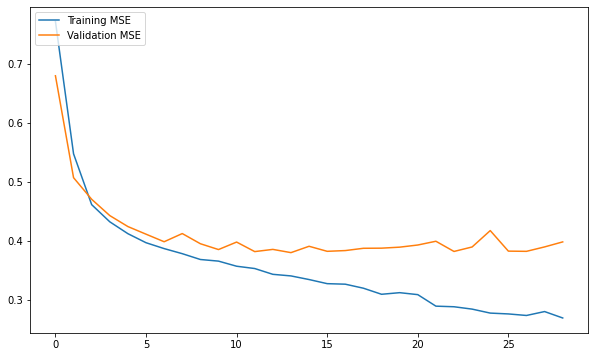

In [ ]:
plt.figure(figsize=(10,6 ))
plt.plot(history.history['loss'],label='Training MSE')
plt.plot(history.history['val_loss'], label='Validation MSE')
plt.legend(loc="upper left")
plt.show()

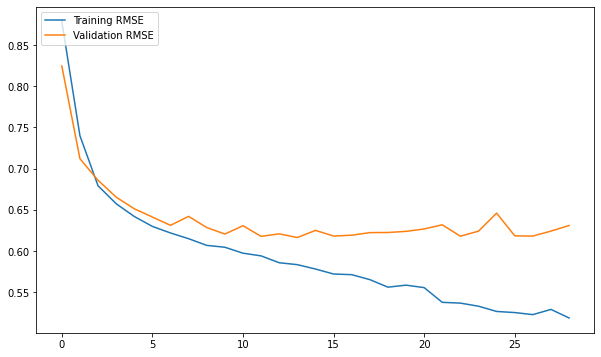

In [ ]:
plt.figure(figsize=(10,6 ))
plt.plot(history.history['root_mean_squared_error'],label='Training RMSE')
plt.plot(history.history['val_root_mean_squared_error'],label='Validation RMSE')
plt.legend(loc="upper left")
plt.show()

In [ ]:
p_train=lstm_model.predict(x_train)
p_val=lstm_model.predict(x_val)
p_test=lstm_model.predict(x_test)

y_train_inv=(y_train*forcing_std['totalSnow_cm'])+forcing_mean['totalSnow_cm']
p_train_inv=(p_train*forcing_std['totalSnow_cm'])+forcing_mean['totalSnow_cm']

y_val_inv=(y_val*forcing_std['totalSnow_cm'])+forcing_mean['totalSnow_cm']
p_val_inv=(p_val*forcing_std['totalSnow_cm'])+forcing_mean['totalSnow_cm']

y_test_inv=(y_test*forcing_std['totalSnow_cm'])+forcing_mean['totalSnow_cm']
p_test_inv=(p_test*forcing_std['totalSnow_cm'])+forcing_mean['totalSnow_cm']

In [ ]:
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
def evaluate_forecasts(test, forecasts, n_seq):
 for i in range(n_seq):
  actual = [row[i] for row in test]
  predicted = [forecast[i] for forecast in forecasts]
  rmse = sqrt(mean_squared_error(actual, predicted))
  mae = mean_absolute_error(actual, predicted)
  r2=r2_score(actual, predicted)
  print('t+%s RMSE: %s , MAE: %s , R2: %s' % ((i+1), rmse,mae,r2))



In [ ]:
evaluate_forecasts(y_test_inv, p_test_inv, 4)

t+1 RMSE: 0.6885278223518715 , MAE: 0.17026889596574157 , R2: 0.8172030483113818
t+2 RMSE: 0.9081970712767747 , MAE: 0.253430592002791 , R2: 0.681956770258568
t+3 RMSE: 1.0803397460157511 , MAE: 0.3316659001413658 , R2: 0.5499646078456297
t+4 RMSE: 1.218636032403594 , MAE: 0.400117280731239 , R2: 0.4273701393995102


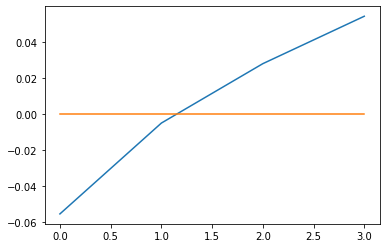

In [ ]:
plt.plot(p_test_inv[-2])
plt.plot(y_test_inv[-2])

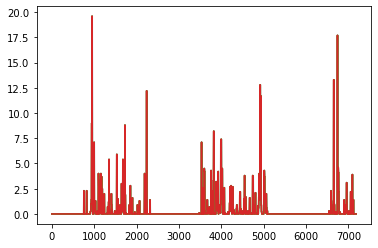

In [ ]:
plt.plot(y_test_inv)

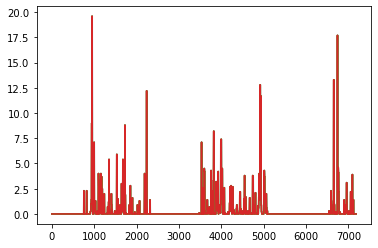

In [ ]:
plt.plot(y_test_inv)

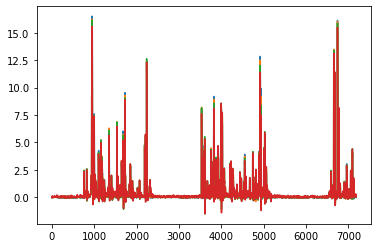

In [ ]:
plt.plot(p_test_inv.reshape(7184, 4))